In [1]:
import networkx as nx
from matplotlib import pyplot as plt
import numpy as np

In [2]:
from cbsim.net import Net
from cbsim.request import Request
from cbsim.stochastic import Stochastic

<H1> Run simulations

In [3]:
net = Net()
net.load_from_file(fnodes='nodes.txt', flinks='links.txt')

In [4]:
flows = {
    0: 209,  # Sławkowska
    2: 113,  # Szczepańska
    4: 309,  # Św. Anny
    5: 139,  # Franciszkańska
    6: 256,  # Poselska
    10: 378, # Sienna
    12: 129  # Szpitalna
}
probs = { 'R': 1, 'H': 1, 'S': 1, 'P': 1, 'W': 1 }
loadpoints = {15: 'A', 28: 'B', 24: 'C', 19: 'D', 8: 'E', 20: 'F'}

itscs = [nd for nd in net.nodes if nd.type == 'N']
clients = [nd for nd in net.nodes if nd.type != 'N' and nd.type != 'L']
_total = sum(flows.values()) # total number of requests to generate
generated = 0
reqs = []
while generated < _total:
    dst = np.random.choice(clients)
    if np.random.random() < probs[dst.type]:
        req = Request(0, None, dst)
        generated += 1
        reqs.append(req)

rs = net.gen_demand(flows, probs,
                    reqs,
                    Stochastic(),
                    traditional=False)
trs = net.gen_demand(flows, probs,
                     reqs,
                     Stochastic(),
                     traditional=True)

In [5]:
print(len(rs), sum(flows.values()))
print(len(trs), sum(flows.values()))

1533 1533
1531 1533


<H1>Visualisation

In [6]:
nodes = net.nodes

min_x, max_x = 100, 0
min_y, max_y = 100, 0

for nd in nodes:
    if nd.x < min_x: min_x = nd.x
    if nd.y < min_y: min_y = nd.y
    if nd.x > max_x: max_x = nd.x
    if nd.y > max_y: max_y = nd.y

print(min_x, max_x, min_y, max_y)
# normalize coordinates
for nd in nodes:
    nd.x = (nd.x - min_x) / (max_x - min_x)
    nd.y = (nd.y - min_y) / (max_y - min_y)

50.054102 50.066268 19.932081 19.944102


<H2>Client types

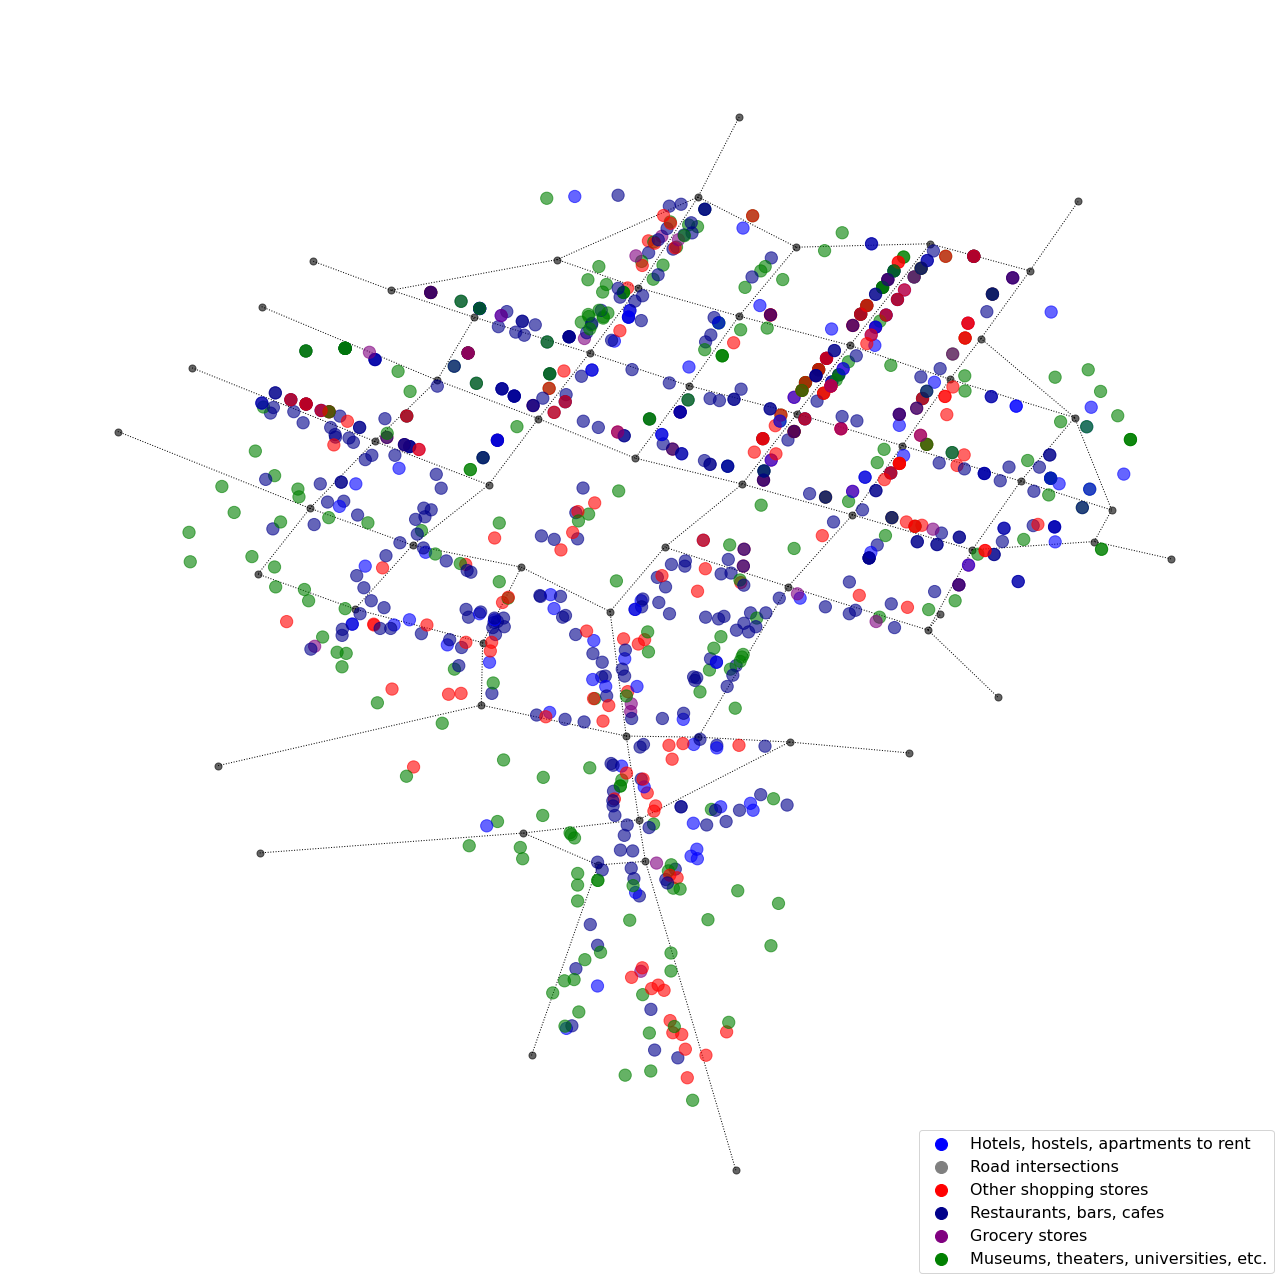

In [7]:
G = nx.Graph()

for nd in nodes:
    G.add_node(nd.nid, pos=(nd.y, nd.x))
for lnk in net.links:
    G.add_edge(lnk.out_node.nid, lnk.in_node.nid)

pos = nx.get_node_attributes(G, 'pos')

color_map = {
    'R': 'darkblue',
    'H': 'blue',
    'S': 'purple',
    'P': 'red',
    'W': 'green',
    'N': 'grey',
}
node_type_name = {
    'R': 'Restaurants, bars, cafes',
    'H': 'Hotels, hostels, apartments to rent',
    'S': 'Grocery stores',
    'P': 'Other shopping stores',
    'W': 'Museums, theaters, universities, etc.',
    'N': 'Road intersections',
    'L': 'Loading points'
}
colors = [color_map.get(nd.type) for nd in nodes]

fig = plt.figure(figsize=(18, 18))

ax = fig.add_subplot(1, 1, 1)
for label in sorted(color_map):
    ax.scatter([], [], color=color_map[label], label=node_type_name[label])

nx.draw_networkx_nodes(G,
                       pos=pos,
                       nodelist=range(len(itscs)),
                       alpha=0.6,
                       node_color='black', #'white',
                       node_size=50
                      )
nx.draw_networkx_nodes(G,
                       pos=pos,
                       nodelist=range(len(itscs), len(net.nodes)),
                       alpha=0.6,
                       node_color=colors[len(itscs):],
                       node_size=150
                      )

# nx.draw_networkx_labels(G, pos, labels={nd: nd for nd in G.nodes()}, font_size=10)

nx.draw_networkx_edges(G, 
                       pos=pos,
                       style='dotted')

plt.axis('off')
plt.legend(loc='lower right', fontsize=16, markerscale=2.0)
fig.tight_layout()
# plt.savefig("client_map_s.png", dpi=300)
plt.show()

In [8]:
type_map = {'R': 0, 'H': 0, 'S': 0, 'P': 0, 'W': 0, 'N': 0, 'L': 0}
for nd in nodes:
    type_map[nd.type] += 1
type_map

{'R': 380, 'H': 108, 'S': 28, 'P': 184, 'W': 254, 'N': 60, 'L': 0}

<H2> Traffic Analysis Zones

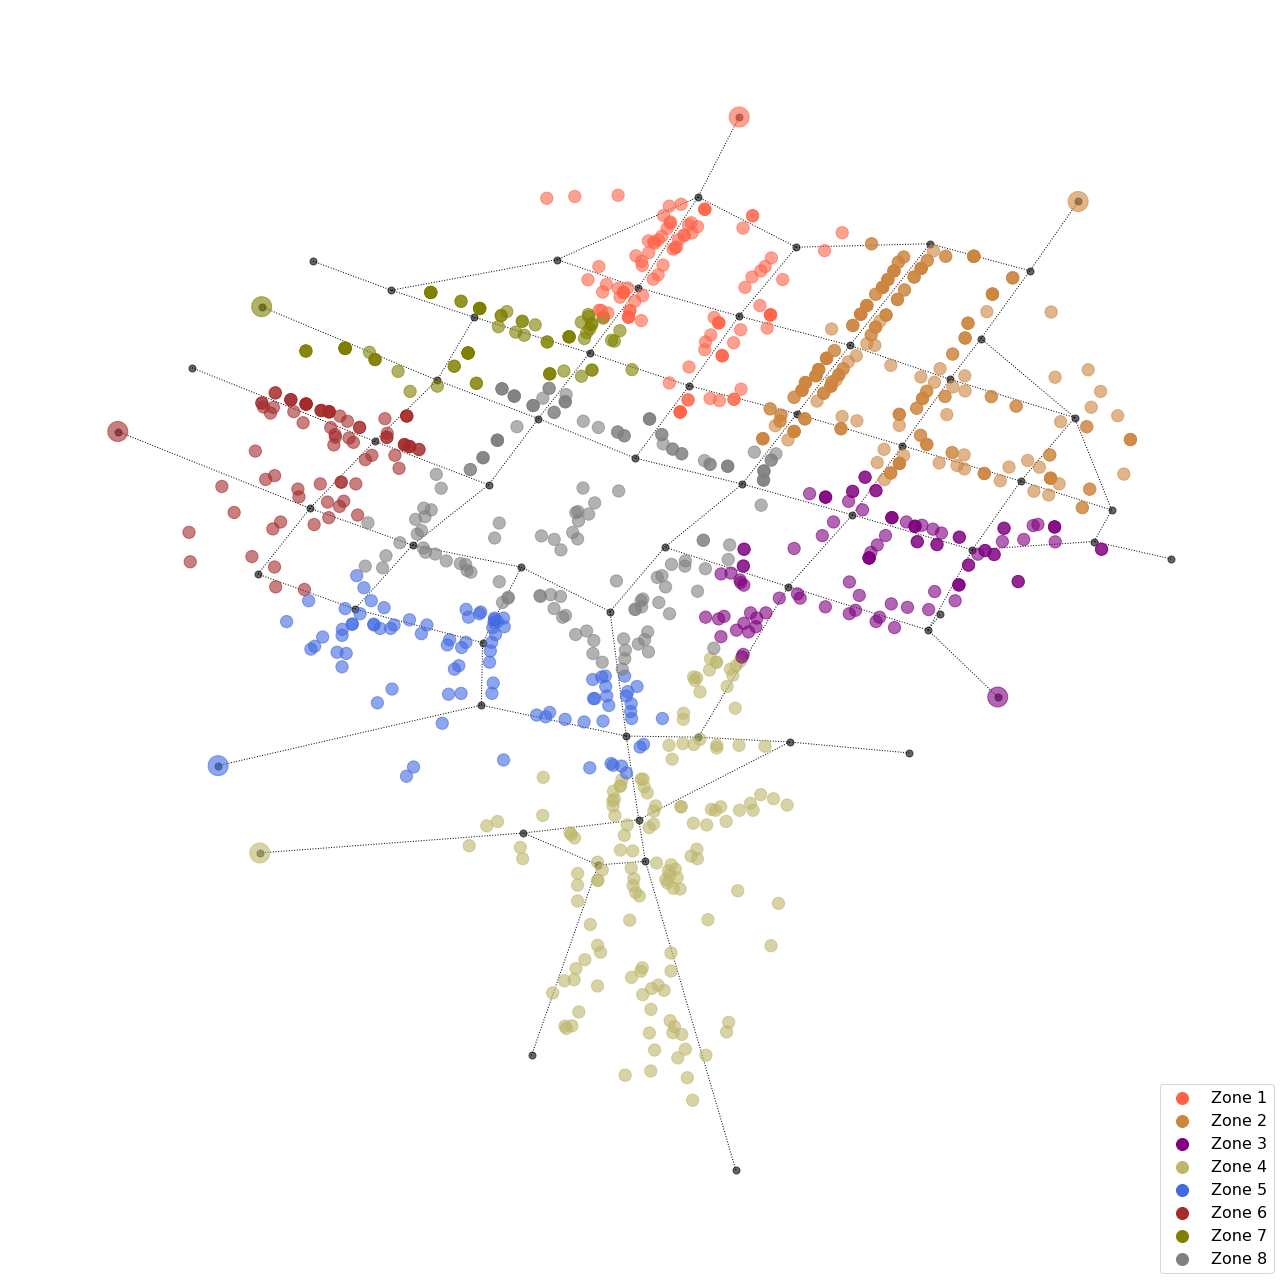

In [10]:
G = nx.Graph()

for nd in nodes:
    G.add_node(nd.nid, pos=(nd.y, nd.x))
for lnk in net.links:
    G.add_edge(lnk.out_node.nid, lnk.in_node.nid)

pos = nx.get_node_attributes(G, 'pos')

inlets = list(flows.keys())


color_map = {
    0: 'tomato',
    1: 'peru',
    2: 'purple',
    3: 'darkkhaki',
    4: 'royalblue',
    5: 'brown',
    6: 'olive',
    7: 'grey',
}

node_type_name = {}
for i in range(len(net.regions)):
    node_type_name[i] = 'Zone {}'.format(i + 1) 

colors = [color_map.get(nd.closest_itsc.region.code) for nd in nodes]

fig = plt.figure(figsize=(18, 18))

ax = fig.add_subplot(1, 1, 1)
for label in sorted(color_map):
    ax.scatter([], [], color=color_map[label], label=node_type_name[label])

nx.draw_networkx_nodes(G,
                       pos=pos,
                       nodelist=range(len(itscs)),
                       alpha=0.6,
                       node_color='black',
                       node_size=50
                      )

nx.draw_networkx_nodes(G,
                       pos=pos,
                       nodelist=inlets,
                       alpha=0.6,
                       node_color=[color_map[net.get_node(inlet).closest_itsc.region.code]
                                   for inlet in inlets],
                       node_size=400
                      )

nx.draw_networkx_nodes(G,
                       pos=pos,
                       nodelist=range(len(itscs), len(net.nodes)),
                       alpha=0.6,
                       node_color=colors[len(itscs):],
                       node_size=150
                      )

# nx.draw_networkx_labels(G, pos, names, font_size=10)

nx.draw_networkx_edges(G, 
                       pos=pos,
                       style='dotted')

plt.axis('off')
plt.legend(loc='lower right', fontsize=16, markerscale=2.0)
fig.tight_layout()
# plt.savefig("client_map_s.png", dpi=300)
plt.show()

<H2>Demand distribution per inlet

ITSC1: [1.0, 0.5899675567756152], N


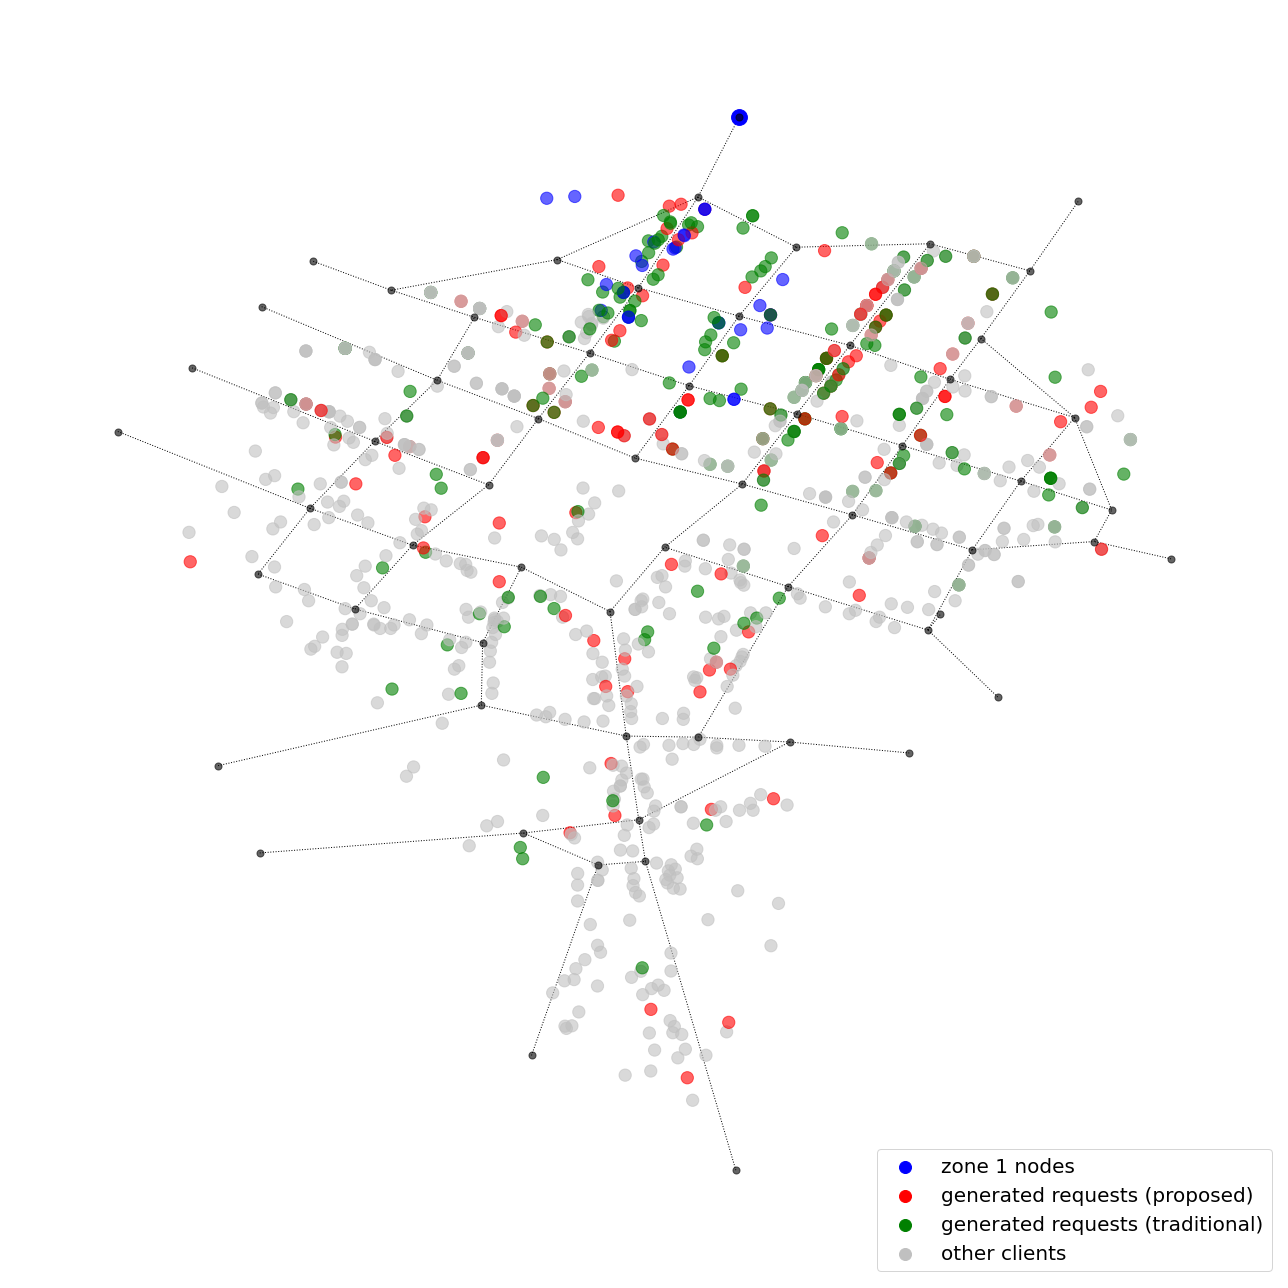

In [25]:
zone = 0

entry = None
for f in flows:
    inlet = net.get_node(f)
    if inlet.region.code == zone:
        entry = inlet
        break

print(entry)

destinations = [
    req.destination for req in rs
    if req.origin.region.code == zone
]
tdestinations = [
    req.destination for req in trs
    if req.origin.region.code == zone
]
znodes = [
    nd for nd in nodes
    if nd.closest_itsc.region.code == zone
]

G = nx.Graph()

for nd in nodes:
    G.add_node(nd.nid, pos=(nd.y, nd.x))
for lnk in net.links:
    G.add_edge(lnk.out_node.nid, lnk.in_node.nid)

pos = nx.get_node_attributes(G, 'pos')

colors = ['silver' for nd in nodes]
for i in range(len(nodes)):
    if nodes[i] in znodes:
        colors[i] = 'blue'
    if nodes[i] in destinations:
        colors[i] = 'red'
    if nodes[i] in tdestinations:
        colors[i] = 'green'

color_map = {
    'zone {} nodes'.format(zone + 1): 'blue',
    'generated requests (proposed)': 'red',
    'generated requests (traditional)': 'green',
    'other clients': 'silver'
}

fig = plt.figure(figsize=(18, 18))

ax = fig.add_subplot(1, 1, 1)
for label in color_map:
    ax.scatter([], [], color=color_map[label], label=label)

nx.draw_networkx_nodes(G,
                       pos={entry.nid: pos[entry.nid]},
                       nodelist=[entry.nid],
                       alpha=1.0,
                       node_color='blue',
                       node_size=250
                      )
nx.draw_networkx_nodes(G,
                       pos=pos,
                       nodelist=range(len(itscs), len(net.nodes)),
                       alpha=0.6,
                       node_color=colors[len(itscs):],
                       node_size=150
                      )

nx.draw_networkx_nodes(G,
                       pos=pos,
                       nodelist=range(len(itscs)),
                       alpha=0.6,
                       node_color='black',
                       node_size=50
                      )

# nx.draw_networkx_labels(G, pos, names, font_size=10)

nx.draw_networkx_edges(G, 
                       pos=pos,
                       style='dotted')

plt.axis('off')
plt.legend(loc='lower right', fontsize=20, markerscale=2.0)
fig.tight_layout()
# plt.savefig("client_map_s.png", dpi=300)
plt.show()

<H2> Loadpoints location

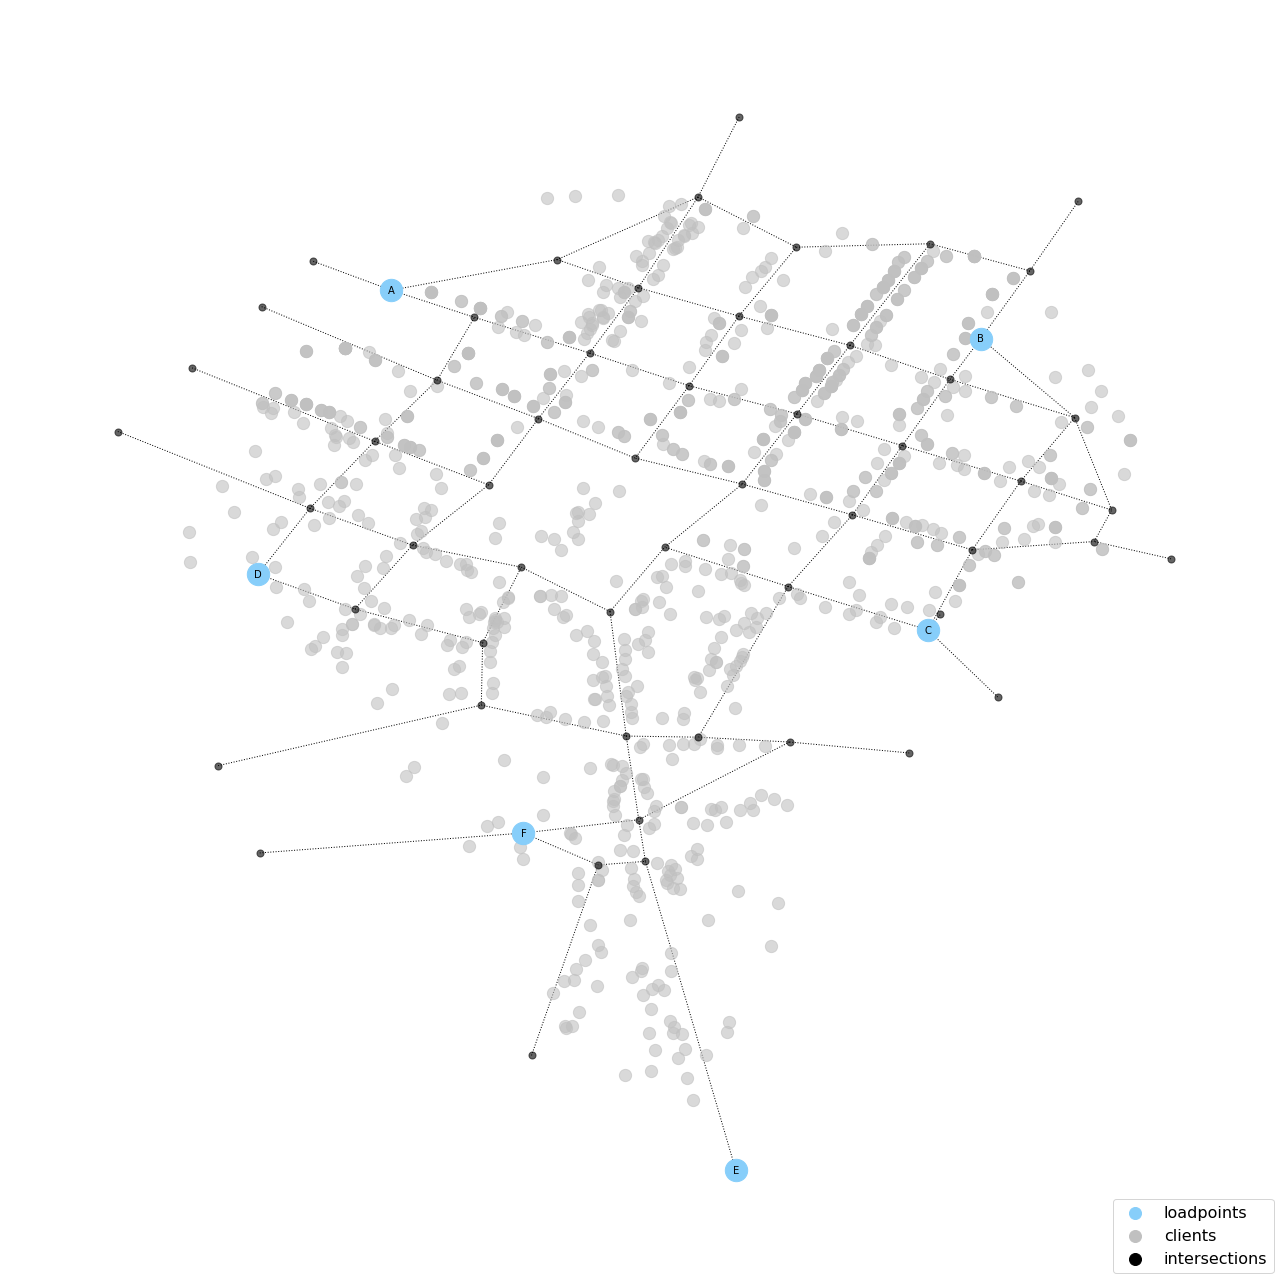

In [26]:
G = nx.Graph()

for nd in nodes:
    G.add_node(nd.nid, pos=(nd.y, nd.x))
for lnk in net.links:
    G.add_edge(lnk.out_node.nid, lnk.in_node.nid)

pos = nx.get_node_attributes(G, 'pos')

color_map = {
    'loadpoints': 'lightskyblue',
    'clients': 'silver',
    'intersections': 'black'
}

fig = plt.figure(figsize=(18, 18))

ax = fig.add_subplot(1, 1, 1)
for label in color_map:
    ax.scatter([], [], color=color_map[label], label=label)

nx.draw_networkx_edges(G, 
                       pos=pos,
                       style='dotted')

nx.draw_networkx_nodes(G,
                       pos=pos,
                       nodelist=range(len(itscs), len(net.nodes)),
                       alpha=0.6,
                       node_color=color_map['clients'],
                       node_size=150)

nx.draw_networkx_nodes(G,
                       pos=pos,
                       nodelist=range(len(itscs)),
                       alpha=0.6,
                       node_color=color_map['intersections'],
                       node_size=50)

nx.draw_networkx_nodes(G,
                       pos={nd: pos[nd] for nd in G.nodes() if nd in loadpoints.keys()},
                       nodelist=loadpoints.keys(),
                       alpha=1.0,
                       node_color=color_map['loadpoints'],
                       node_size=500)

nx.draw_networkx_labels(G,
                        pos={nd: pos[nd] for nd in G.nodes() if nd in loadpoints.keys()},
                        labels=loadpoints, font_size=10)

plt.axis('off')
plt.legend(loc='lower right', fontsize=16, markerscale=2.0)
fig.tight_layout()
# plt.savefig("client_map_s.png", dpi=300)
plt.show()